# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [78]:
import os
import numpy as np
from typing import Tuple
from skimage import color, data
import imageio
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from scipy import datasets
from scipy.fft import dctn, idctn
from skimage.color import rgb2ycbcr

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

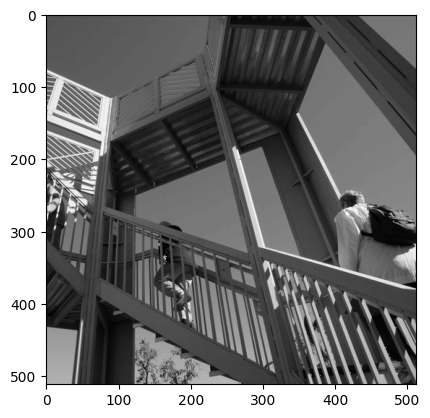

In [79]:
X = datasets.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

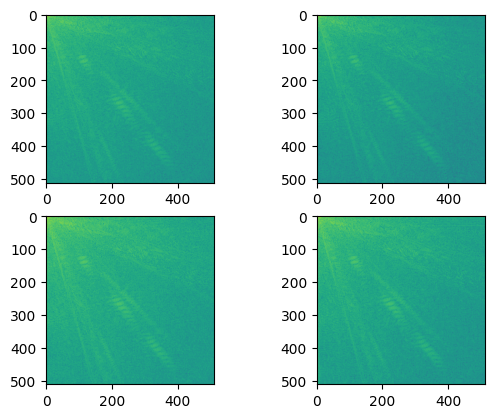

In [80]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)

freq_db_1 = 20 * np.log10(abs(Y1))
freq_db_2 = 20 * np.log10(abs(Y2))
freq_db_3 = 20 * np.log10(abs(Y3))
freq_db_4 = 20 * np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)

plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

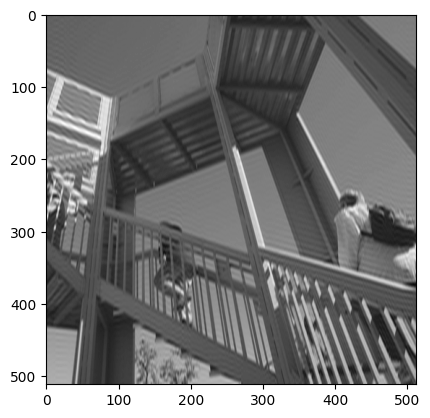

In [81]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

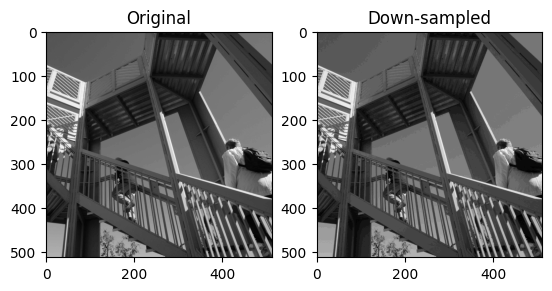

In [82]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

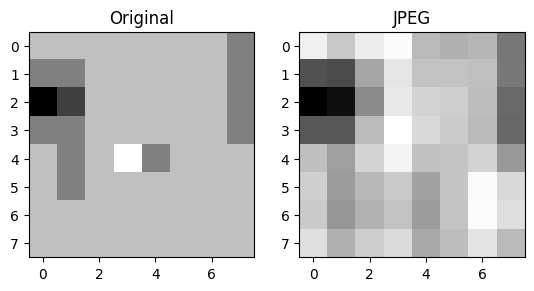

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [83]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

### Utils

In [84]:
Q_jpeg = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 28, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

def compress_channel(channel: np.ndarray, Q: np.ndarray) -> np.ndarray:
    dct_channel = dctn(channel, norm='ortho')
    return Q * np.round(dct_channel / Q)

def decompress_channel(quantized_channel: np.ndarray) -> np.ndarray:
    return idctn(quantized_channel, norm='ortho')

def compress_decompress_blocks(channel: np.ndarray, Q: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    rows, cols = channel.shape
    block_size = 8

    compressed_channel = np.zeros_like(channel)
    decompressed_channel = np.zeros_like(channel)

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = channel[i : i+block_size, j : j+block_size]
            compressed_block = compress_channel(block, Q)
            decompressed_block = decompress_channel(compressed_block)

            compressed_channel  [i : i+block_size, j : j+block_size] = compressed_block
            decompressed_channel[i : i+block_size, j : j+block_size] = decompressed_block

    return compressed_channel, decompressed_channel

def show_images(images: list, titles: list, cmap=plt.cm.gray, file_name: str = None) -> None:
    num_images = len(images)

    if num_images != len(titles):
        raise ValueError("The number of images should match the number of titles.")

    num_cols = 3
    num_rows = np.ceil(num_images / num_cols).astype(int)

    plt.figure(figsize=(4 * num_cols, 4 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1).imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        
    if file_name:
        plt.savefig(file_name)

    plt.tight_layout()
    plt.show()

### Sarcina 1

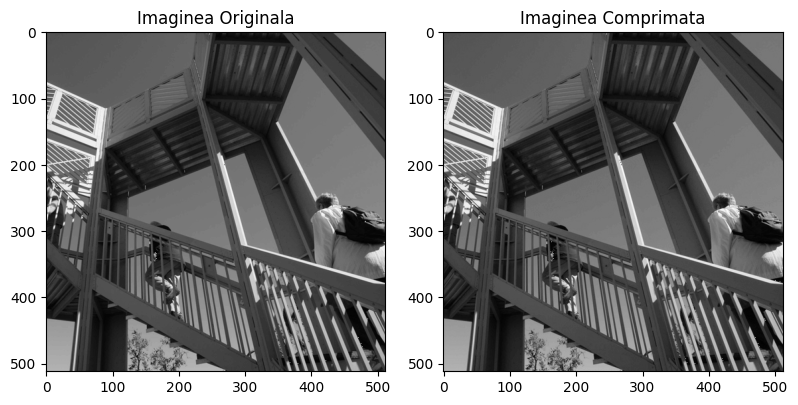

In [85]:
def compress_image(image: np.ndarray, Q_matrix: np.ndarray) -> np.ndarray:
    block_size = 8
    rows, cols = image.shape[:2]

    quantized_blocks = np.zeros_like(image)
    compressed_image = np.zeros_like(image)

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            # Extrage un bloc de 8x8 pixeli
            block = image[i : i+block_size, j : j+block_size]
            
            # Aplica DCT pe bloc
            dct_block = dctn(block)

            # Aplica cuantizarea pe blocul DCT
            quantized_block = Q_matrix * np.round(dct_block / Q_matrix)
            quantized_blocks[i : i+block_size, j : j+block_size] = quantized_block

            # Aplica IDCT pe blocul cuantizat
            idct_block = idctn(quantized_block)
            compressed_image[i : i+block_size, j : j+block_size] = idct_block

    return compressed_image

image = datasets.ascent()
compressed_image = compress_image(image, Q_jpeg)

show_images(images=[image, compressed_image], titles=['Imaginea Originala', 'Imaginea Comprimata'])

### Sarcina 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


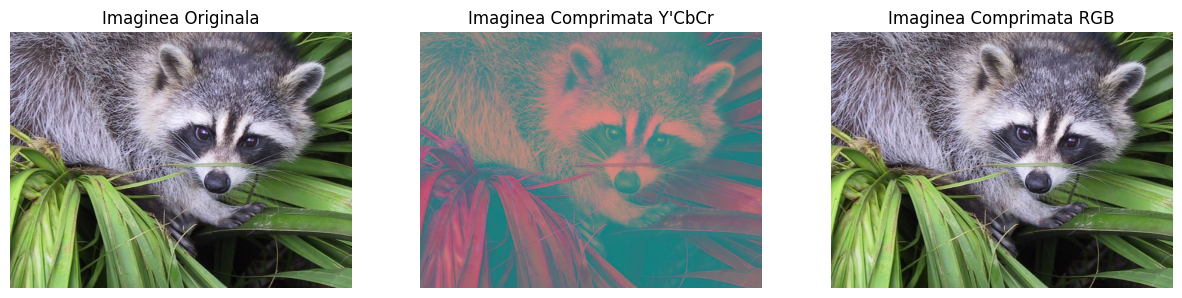

In [106]:
image_rgb = datasets.face()
image_ycbcr = color.rgb2ycbcr(image_rgb)

y_channel = image_ycbcr[:, :, 0]
cb_channel = image_ycbcr[:, :, 1]
cr_channel = image_ycbcr[:, :, 2]

compressed_y, decompressed_y = compress_decompress_blocks(y_channel, Q_jpeg)
compressed_cb, decompressed_cb = compress_decompress_blocks(cb_channel, Q_jpeg)
compressed_cr, decompressed_cr = compress_decompress_blocks(cr_channel, Q_jpeg)

# Normalizare si scalare in intervalul [0, 255]
normalized_compressed_y  = np.clip(decompressed_y, 0, 255).astype(np.uint8)
normalized_compressed_cb = np.clip(decompressed_cb, 0, 255).astype(np.uint8)
normalized_compressed_cr = np.clip(decompressed_cr, 0, 255).astype(np.uint8)

# Reconstruirea imaginii Y'CbCr
compressed_ycbcr = np.stack([normalized_compressed_y, normalized_compressed_cb, normalized_compressed_cr], axis=-1)
compressed_rgb = color.ycbcr2rgb(np.stack([decompressed_y, decompressed_cb, decompressed_cr], axis=-1))

show_images(
    images=[image_rgb, compressed_ycbcr, compressed_rgb], 
    titles=['Imaginea Originala', 'Imaginea Comprimata Y\'CbCr', 'Imaginea Comprimata RGB'],
    cmap=plt.cm.viridis
)

### Sarcina 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE final pentru canalul Y: 10.0
MSE final pentru canalul Cb: 0.6674661083124006
MSE final pentru canalul Cr: 0.5418635481316059


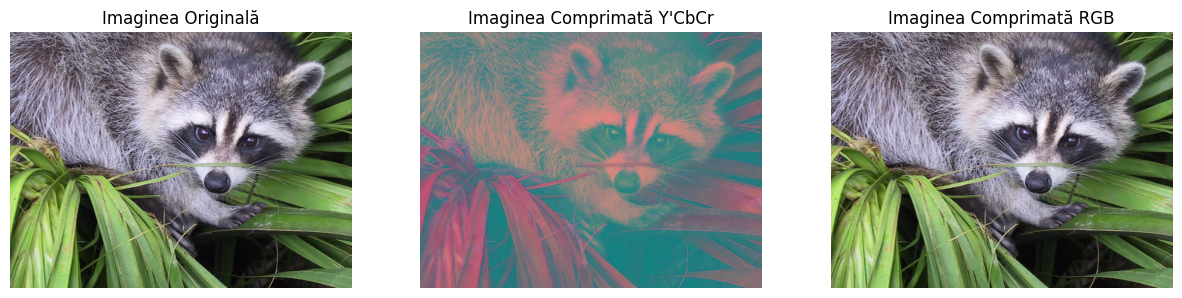

In [110]:
def calculate_mse(original, compressed):
    return mean_squared_error(original, compressed)

image_rgb = datasets.face()
image_ycbcr = color.rgb2ycbcr(image_rgb)

y_channel = image_ycbcr[:, :, 0]
cb_channel = image_ycbcr[:, :, 1]
cr_channel = image_ycbcr[:, :, 2]

# Setarea MSE-ului dorit
target_mse = 10
current_mse_y = float('inf')
current_mse_cb = float('inf')
current_mse_cr = float('inf')

while current_mse_y > target_mse or current_mse_cb > target_mse or current_mse_cr > target_mse:
    # Comprimarea și decompresia pentru fiecare canal
    compressed_y, decompressed_y = compress_decompress_blocks(y_channel, Q_jpeg)
    compressed_cb, decompressed_cb = compress_decompress_blocks(cb_channel, Q_jpeg)
    compressed_cr, decompressed_cr = compress_decompress_blocks(cr_channel, Q_jpeg)

    # Calculul MSE pentru fiecare canal
    current_mse_y = calculate_mse(y_channel, decompressed_y)
    current_mse_cb = calculate_mse(cb_channel, decompressed_cb)
    current_mse_cr = calculate_mse(cr_channel, decompressed_cr)

    # Ajustarea matricei Q pentru a obține un MSE mai mic pentru fiecare canal în parte
    Q_jpeg *= np.sqrt(target_mse / current_mse_y)

print(f"MSE final pentru canalul Y: {current_mse_y}")
print(f"MSE final pentru canalul Cb: {current_mse_cb}")
print(f"MSE final pentru canalul Cr: {current_mse_cr}")

# Normalizare și scalare în intervalul [0, 255]
normalized_compressed_y  = np.clip(decompressed_y, 0, 255).astype(np.uint8)
normalized_compressed_cb = np.clip(decompressed_cb, 0, 255).astype(np.uint8)
normalized_compressed_cr = np.clip(decompressed_cr, 0, 255).astype(np.uint8)

# Reconstruirea imaginii Y'CbCr
compressed_ycbcr = np.stack([normalized_compressed_y, normalized_compressed_cb, normalized_compressed_cr], axis=-1)
compressed_rgb = color.ycbcr2rgb(np.stack([decompressed_y, decompressed_cb, decompressed_cr], axis=-1))

show_images(
    images=[image_rgb, compressed_ycbcr, compressed_rgb],
    titles=['Imaginea Originală', 'Imaginea Comprimată Y\'CbCr', 'Imaginea Comprimată RGB'],
    cmap=plt.cm.viridis
)

### Sarcina 4

In [ ]:
video_path = 'orig.mp4'
reader = imageio.get_reader(video_path)

if not os.path.exists('frames'):
    os.mkdir('frames')

for contor, frame_rgb in enumerate(reader):
    image_ycbcr = rgb2ycbcr(frame_rgb)

    y_channel = image_ycbcr[:, :, 0]
    cb_channel = image_ycbcr[:, :, 1]
    cr_channel = image_ycbcr[:, :, 2]
    
    compressed_y, decompressed_y = compress_decompress_blocks(y_channel, Q_jpeg)
    compressed_cb, decompressed_cb = compress_decompress_blocks(cb_channel, Q_jpeg)
    compressed_cr, decompressed_cr = compress_decompress_blocks(cr_channel, Q_jpeg)
    
    # Normalizare si scalare in intervalul [0, 255]
    normalized_compressed_y  = np.clip(decompressed_y, 0, 255).astype(np.uint8)
    normalized_compressed_cb = np.clip(decompressed_cb, 0, 255).astype(np.uint8)
    normalized_compressed_cr = np.clip(decompressed_cr, 0, 255).astype(np.uint8)
    
    # Reconstruirea imaginii Y'CbCr
    compressed_ycbcr = np.stack([normalized_compressed_y, normalized_compressed_cb, normalized_compressed_cr], axis=-1)
    compressed_rgb = color.ycbcr2rgb(np.stack([decompressed_y, decompressed_cb, decompressed_cr], axis=-1))

    show_images(
        images=[frame_rgb, compressed_ycbcr, compressed_rgb],
        titles=['Imaginea Originala', 'Imaginea Comprimata Y\'CbCr', 'Imaginea Comprimata RGB'],
        cmap=plt.cm.viridis,
        file_name=os.path.join('frames', f"frame_{contor}.png")
    )

reader.close()